In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [298]:
def plot_loss(loss_train, loss_val):
    plt.plot(np.arange(len(loss_train)), loss_train, label='train')
    plt.plot(np.arange(0, len(loss_train), len(loss_train) / N), loss_val, label='validate')
    plt.legend()
    plt.title("losses")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.show()

In [174]:
def loss(data):
    return -torch.sum(torch.log(data))

In [175]:
image = np.load('./distribution.npy')

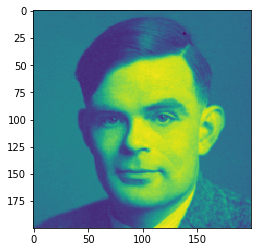

In [176]:
plt.imshow(image)

In [301]:
def make(size=200):
    return np.array([[(i, j) for j in np.arange(size)] for i in np.arange(size)], dtype=np.int64)

In [380]:
def make_one_hot_mlp(x):
    x1, x2 = x[:,0], x[:,1]
    oh = torch.zeros((x.shape[0], 200))
    oh[np.arange(x.shape[0]), x1] = 1.0
    
    return oh

In [345]:
def make_one_hot(x):
    oh = torch.zeros((x.shape[0], 400), dtype=torch.float).float()
    oh[np.arange(x.shape[0]), x[:,0]] = 1.0
    oh[np.arange(x.shape[0]), 200 + x[:,1]] = 1.0
    
    return oh.float()

In [302]:
def sample_data():
    distribution = np.load('./distribution.npy')
    distribution_ravel = distribution.ravel()
    pairs = make(size=distribution.shape[0])
    idx = np.random.choice(np.arange(len(distribution_ravel)), 100000, p=distribution_ravel)
    idx_2d = np.unravel_index(idx, distribution.shape)
    samples = pairs[idx_2d]
    return samples

In [354]:
def make_t(p, v):
    return torch.tensor((p[v][:,None] <= p[1 - v][None,:]).astype(float)).float()
    

In [355]:
def gen_masks():
    p = [np.random.permutation(400), np.random.randint(0, 399, size=400)]
    return make_t(p, 0), make_t(p, 1)

In [381]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.thetas = torch.zeros(200, requires_grad=True)
        self.mlp = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=0.07),
            nn.Linear(200, 200),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        
        p1 = torch.exp(self.thetas[x1]) / torch.sum(torch.exp(self.thetas))
        p2 = self.mlp(make_one_hot_mlp(x))[np.arange(x.shape[0]), x2]

        return p1 * p2
    
    def parameters(self):
        return list(self.mlp.parameters()) + [self.thetas]
    
    def __call__(self, X):
        return self.forward(X)

In [382]:
samples = sample_data()
X_train, X_test = train_test_split(samples, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.125, random_state=42)
N = 12
Nb = 2000
model = MyModel()
ltr, lte, lva = 70000, 20000, 10000

In [383]:
def train():
    optimizer = Adam(model.parameters(), 1e-3)
    train_loader = DataLoader(X_train, batch_size=Nb, shuffle=True)
    loss_train, loss_val = [], []
        
    for epoch in range(N):
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss_ = loss(output)
            loss_train.append(loss_ / (2 * Nb))
            loss_.backward()
            optimizer.step()

        with torch.no_grad():
            loss_val.append(loss(model(X_val)) / (2 * lva))

    with torch.no_grad():
        print("Test loss: " + str(float(loss(model(X_test)) / (2 * lte))))

    return loss_train, loss_val

In [384]:
loss_train, loss_val = train()

Test loss: 5.276628017425537


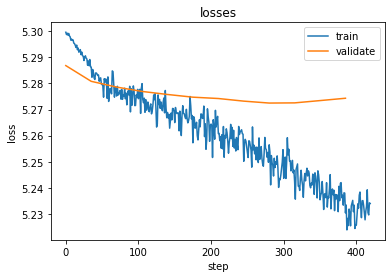

In [385]:
plot_loss(loss_train, loss_val)

In [386]:
x = make().reshape(-1, 2)
probs = model(x)
probs = probs.detach().numpy()
probs = probs.reshape((200, 200))

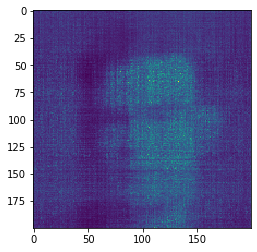

In [387]:
plt.imshow(probs)

In [388]:
def plot_samples(samples, title):
    plt.hist2d(samples[:,0], samples[:,1], bins=200, range=np.array([[0,199], [0,199]]))
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

In [389]:
probs_ = probs.ravel()
idx = np.random.choice(np.arange(len(probs_)), 100000, p=probs_ / probs_.sum())
samples = make()[np.unravel_index(idx, probs.shape)]

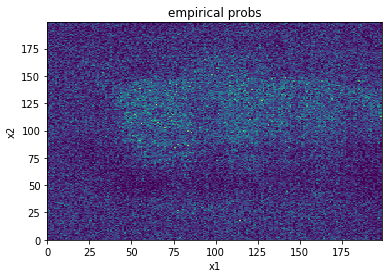

In [390]:
plot_samples(samples, "empirical probs")

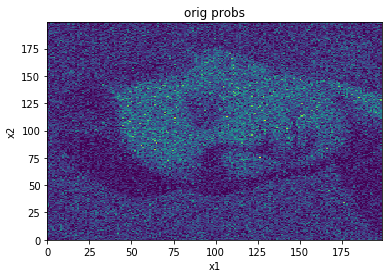

In [391]:
plot_samples(sample_data(), "orig probs")

In [309]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.mask = mask.float()
        
    def forward(self, input):
        return torch.nn.functional.linear(input, self.mask * self.weight, self.bias)

In [369]:
class MADE(nn.Module):
    def __init__(self):
        super().__init__()
        
        m1, m2 = gen_masks()
        
        self.model = nn.Sequential(
            MaskedLinear(400, 400, m1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            MaskedLinear(400, 400, m2)
        )
        
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        p = self.softmax(self.model(make_one_hot(x)).view(-1, 2, 200))
        return torch.gather(p, 2, torch.tensor(x.reshape(len(x), -1, 1))).view(len(x), 2)
    
    def parameters(self):
        return list(self.model.parameters()) + list(self.softmax.parameters())
    

In [370]:
N=50
Nb=1000
model = MADE()
model = model.float()
optimizer = Adam(model.parameters(), 1e-3)

In [371]:
def trainMADE():
    train_loader = DataLoader(X_train, batch_size=Nb, shuffle=True)
    loss_train, loss_val = [], []
        
    for epoch in range(N):
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss_ = loss(output)
            loss_train.append(loss_ / (2 * Nb))
            loss_.backward()
            optimizer.step()

        with torch.no_grad():
            loss_val.append(loss(model(X_val)) / (2 * lva))

    with torch.no_grad():
        print("Test loss: " + str(float(loss(model(X_test)) / (2 * lte))))

    return loss_train, loss_val

In [375]:
loss_train, loss_val = trainMADE()

Test loss: 1.5661321878433228


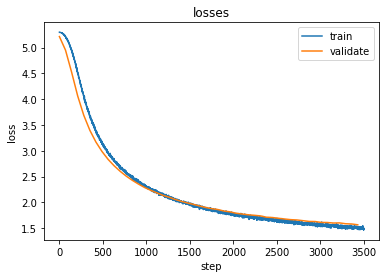

In [373]:
plot_loss(loss_train, loss_val)

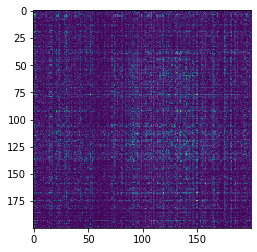

In [374]:
probs = model(make().reshape(-1, 2)).detach().numpy()
probs = np.array([probs[i][0] * probs[i][1] for i in range(len(probs))]).reshape((200, 200))
plt.imshow(probs)

In [326]:
probs_ = probs.ravel()
idx = np.random.choice(np.arange(len(probs_)), 100000, p=probs_ / probs_.sum())
samples = make()[np.unravel_index(idx, probs.shape)]

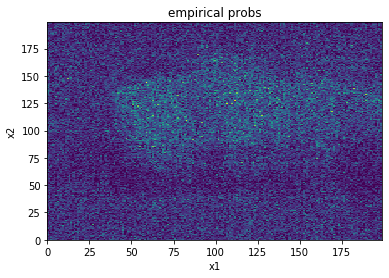

In [348]:
plot_samples(samples, "empirical probs")

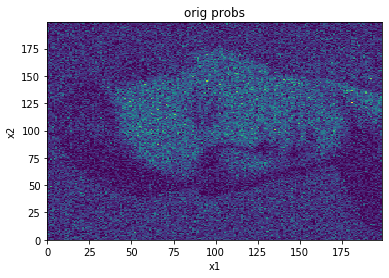

In [339]:
plot_samples(sample_data(), "orig probs")